The question that every car owner has: should he arrange the paid delivery to the main closest airport. 
This experiment is focused on affect on the utilization rate (UR, % days rented per month) since maximizing this feature will lead to maximizing the profit for the customer.

**Results**:
The data was scrapped from the website "Turo.com" - the biggest car sharing platform (by google.com) 

**Hypothesis:** We need to define if the availability of the paid delivery feature will lead to UR increase 

**Rollout Plan**
Ideally, we would like to conduct a controlled experiment but for this case we will use retospecive analysis of the data for the previous month, limited to one state.

**Success Metric**
It will be signigicant enough for us to regect the null hypothesis with the p value>=0.05, OEC - UR

In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
%matplotlib inline
import seaborn as sns
from pandas import ExcelWriter
from pandas import ExcelFile
import math as mt
import scipy.stats as stats


In [122]:
df = pd.read_excel ('!!MAIN!Workbook_Turo_March.xlsx',
    sheet_name='DATA',
    skiprows=[1] # header data
)

Selecting only active listings and limiting our to California

In [123]:
#filtering only Active listings
df = df[df['Status'] =="Active"]
df = df[df['State'] == 'CA']
#replace column name
df.rename(columns={'Airport Delivery fee':'fee'}, inplace=True)

Creating a plot for listings based on their location on a map

In [124]:
df = df[pd.to_numeric(df['Latitude'], errors='coerce').notnull()]
df['Latitude'] = df.Latitude.astype(float)

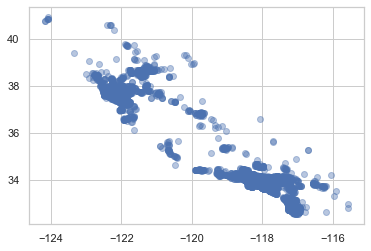

In [125]:
#mapping our location distribution all over the CA
import matplotlib.pyplot as plt
plt.scatter(x=df ['Longitude'], y=df['Latitude'], alpha = 0.4)
plt.show()

Checking the set 

In [126]:
df.groupby('Category').size().sort_values(ascending=False)

Category
Intermediate    3525
Economy         2076
Premium         1680
Exotic          1644
Premium SUV     1407
SUV             1328
Convertible      998
Electric         733
Minivan          447
Truck            325
Retro            178
VAN               22
 Exotic           13
Cargo VAN          7
dtype: int64

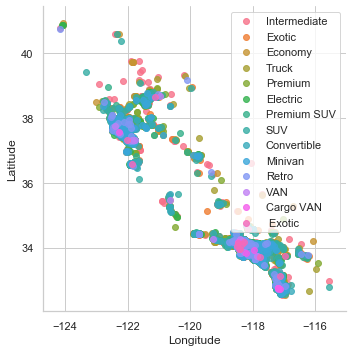

In [127]:
sns.lmplot( x="Longitude", y="Latitude", data=df, fit_reg=False, hue='Category', legend=False)
 
# Move the legend to an empty part of the plot
plt.legend(loc='upper right')

In [128]:
df ['fee']. value_counts()

Free          1140
Up to $120     817
120            357
50             339
Up to $100     297
30             291
Up to $50      270
40             217
100            200
20             191
Up to $80      174
Up to $60      145
80             133
Up to $70      103
60             102
10              86
Up to $90       82
70              76
Up to $30       73
Up to $40       67
35              63
Up to $110      43
Up to $75       42
25              34
Up to $20       34
90              25
15              22
110             18
65              10
55              10
75               9
Up to $25        9
Up to $35        8
45               7
Up to $65        6
85               5
95               4
Up to $105       4
Up to $45        4
Up to $15        4
Up to $95        3
Up to $10        3
Up to $115       2
Up to $85        2
Up to $55        2
5                2
Name: fee, dtype: int64

In [136]:
# Cleaning the data for the FEE , 
df['fee'].replace(regex=True,inplace=True,to_replace=r'\$', value=r'')
df['fee'].replace(regex=True,inplace=True,to_replace=r'Up to', value=r'')
df['fee'].replace(regex=True,inplace=True,to_replace=r'£', value=r'')
df['fee'].replace(regex=True,inplace=True,to_replace=r'NaN', value=r'-1')
#Cleaning Nan to 0 - no delivery
df['fee'].fillna(0, inplace=True)

In [137]:
#replace 'free' into int
df['fee'] = df['fee'].replace(to_replace =['Free'],
                  value = '-999')
#convert to Int
df['fee'] = df['fee'].astype(int)

In [138]:
# Create a list to store the data
fee_cat = []

# For each row in the column,
for row in df['fee']:
    # if more than a value,
    if row > 0:
        # Append a letter grade
        fee_cat.append('Paid Delivery')
    # else, if free,
    elif row < 0:
        # Append a letter grade
        fee_cat.append('Free')
    # otherwise,
    else:
        # Append a failing grade
       fee_cat.append('No delivery')
        
# Create a column from the list
df['fee_cat'] = fee_cat


In [139]:
df['fee_cat'].value_counts()

No delivery      8848
Paid Delivery    4395
Free             1140
Name: fee_cat, dtype: int64

We are interested in the groups Paid Delivery and No Delivery. Let's see how is this vary withing categories

In [140]:
df['UR'] = ((df['Occupancy Mar 18']+2 - df['Unavailable by owner Mar18']))/((31-df['Unavailable by owner Mar18']))
#remove null
df = df[pd.to_numeric(df['UR'], errors='coerce').notnull()]
#Drop all values that aren't clean 
#remove all negative
df = df[(df[['UR']] > 0).all(1)]
#remove a inll more than 1
df = df[(df[['UR']] < 1).all(1)]
#drop all inf
df.replace([np.inf, -np.inf], np.nan).dropna(subset=["UR"], how="all")


,Car ID,URL,Make,Model,For Category,Category,Trim,Year,Color,Transmission,...,Vehicle protection,numberOfFaqs,regularAirportDeliveryFee,minimumAgeInYearsToRent,numberOfFavorites,highValueVehicle,frequentlyBooked,dateRangeRate,fee_cat,UR
10338,29441,https://turo.com/rentals/suvs/ca/san-bruno/hon...,Honda,Element,HondaElement,SUV,NaN,2003,SILVER,A,...,Turo Standard,1,20,0.0,103,0,0.0,NaN,Paid Delivery,0.363636
25859,62584,https://turo.com/rentals/cars/ca/culver-city/t...,Toyota,Corolla,ToyotaCorolla,Intermediate,NaN,2007,BLUE,A,...,Turo Standard,0,0,0.0,86,0,0.0,NaN,No delivery,0.344828
38612,87587,https://turo.com/rentals/cars/ca/los-angeles/t...,Toyota,Corolla,ToyotaCorolla,Intermediate,NaN,2007,SILVER,A,...,Turo Standard,0,0,0.0,121,0,0.0,NaN,No delivery,0.320000
42119,94705,https://turo.com/rentals/cars/ca/daly-city/for...,Ford,Mustang,FordMustang,Intermediate,NaN,2015,WHITE,A,...,Turo Standard,0,0,0.0,262,0,0.0,NaN,No delivery,0.120000
46160,104327,https://turo.com/rentals/cars/ca/millbrae/pors...,Porsche,Boxster,PorscheBoxster,Exotic,S,2013,GRAY,A,...,Turo Standard,6,Up to $120,0.0,354,0,0.0,NaN,Paid Delivery,0.379310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113782,398525,https://turo.com/rentals/cars/ca/los-angeles/l...,Lexus,IS 250,LexusIS 250,Premium,Base,2007,BLUE,A,...,Turo Standard,0,80,0.0,1,0,NaN,NaN,Paid Delivery,0.035714
113797,398552,https://turo.com/rentals/cars/ca/los-angeles/b...,BMW,3 Series,BMW3 Series,Intermediate,NaN,2012,NaN,A,...,Turo Standard,0,0,0.0,0,0,NaN,NaN,No delivery,0.034483
113899,398755,https://turo.com/rentals/suvs/ca/burlingame/au...,Audi,Q5,AudiQ5,Premium SUV,2.0T Premium Plus quattro,2015,BLACK,A,...,Turo Standard,2,Up to $65,0.0,2,0,NaN,NaN,Paid Delivery,0.034483
113973,398887,https://turo.com/rentals/cars/ca/montclair/toy...,Toyota,Camry,ToyotaCamry,Intermediate,LE,2009,NaN,A,...,Turo Standard,0,0,0.0,0,0,NaN,NaN,No delivery,0.034483


Let's check the statistics for the dataset

In [141]:
cat1 = df[df['fee_cat']=='No delivery'].groupby('Category').mean()
cat2 = df[df['fee_cat']=="Paid Delivery"].groupby('Category').mean()
stats.ttest_ind(cat1['UR'], cat2['UR'])

Ttest_indResult(statistic=-0.6730787514708804, pvalue=0.5079066104555896)

We definitely need to dig deeper into the categories since it might be different within stratified sets.

In [142]:
df['Category'].value_counts()

Intermediate    410
Economy         390
SUV             219
Convertible     195
Premium         170
Premium SUV     166
Electric        107
Exotic          104
Minivan          80
Truck            31
Retro             9
VAN               3
Name: Category, dtype: int64

In [143]:
count = df.groupby(['Category', 'fee_cat']).size()
print(count)

Category      fee_cat      
Convertible   Free              42
              No delivery       46
              Paid Delivery    107
Economy       Free              52
              No delivery      148
              Paid Delivery    190
Electric      Free              13
              No delivery       31
              Paid Delivery     63
Exotic        Free              16
              No delivery       25
              Paid Delivery     63
Intermediate  Free              54
              No delivery      164
              Paid Delivery    192
Minivan       Free              14
              No delivery       26
              Paid Delivery     40
Premium       Free              21
              No delivery       38
              Paid Delivery    111
Premium SUV   Free              32
              No delivery       42
              Paid Delivery     92
Retro         No delivery        5
              Paid Delivery      4
SUV           Free              33
              No delivery  

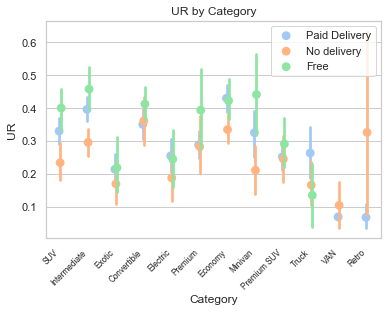

In [17]:
sns.set(style="whitegrid")

g = sns.pointplot(x="Category", y="UR", hue= 'fee_cat', data=df,
                   height=6, kind="strip", palette="pastel",ci=95,dodge=True,join=False)
plt.title('UR by Category')
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize='x-small')
plt.legend(loc='upper right')
plt.show()

We want to do stratified analysis for the car categories since the delivery feature affects different

In [88]:
for cat in df.Category.unique():
    cat_data = df[df.Category == cat]
    print (cat ,'results: ', stats.ttest_ind(cat_data[cat_data.fee_cat == 'Paid Delivery'].UR,
                          cat_data[cat_data.fee_cat == 'No delivery'].UR))

SUV results:  Ttest_indResult(statistic=2.636702591941731, pvalue=0.009087155499678716)
Intermediate results:  Ttest_indResult(statistic=3.7022461422594732, pvalue=0.0002477632195353539)
Exotic results:  Ttest_indResult(statistic=1.0504323850908222, pvalue=0.2964621975423506)
Convertible results:  Ttest_indResult(statistic=-0.2580305213693505, pvalue=0.7967346931498445)
Electric results:  Ttest_indResult(statistic=1.4527782506647122, pvalue=0.14968764612979688)
Premium results:  Ttest_indResult(statistic=0.1033477589664411, pvalue=0.9178278308999971)
Economy results:  Ttest_indResult(statistic=3.169944587830353, pvalue=0.0016649266517221048)
Minivan results:  Ttest_indResult(statistic=2.1152215335039393, pvalue=0.038309354722763166)
Premium SUV results:  Ttest_indResult(statistic=0.16762454314638223, pvalue=0.8671352007347765)
Truck results:  Ttest_indResult(statistic=1.5645800500334288, pvalue=0.1293278463399118)
VAN results:  Ttest_indResult(statistic=nan, pvalue=nan)
Retro results: 

**Conclusions:** From the restrospective analysis we found that for certain car categories the availability of the paid delivery is affecting the UR

We can advise for owners with these types of car to provide delivery (with a fee)
SUV, Intermidiate, Economy, Minivan

Whether owners do delivery or not it won't affect the cars such as Exotic, Electric, Economy, Premium SUV, Truck and Convertible.

**Next steps**: 1) Balancing data set using more data. 2)The research can be extended to the evaluation of ROI considering owner's expences for the delivery, TURO fees and delivery fee.